1. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch
3. *(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.

In [1]:
!pip install segmentation_models_pytorch

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna(axis=1) 
    df = df[[col for col in df if df[col].nunique() > 1]] 
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
    
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) 
    df = df.dropna(axis=1) 
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    

class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255    
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,1]
        f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
        lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len
    
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score
    
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
nRowsRead = 1000 

df1 = pd.read_csv('set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)

df1.dataframeName = 'list.csv'

In [6]:
df1.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


<Figure size 2400x512 with 0 Axes>

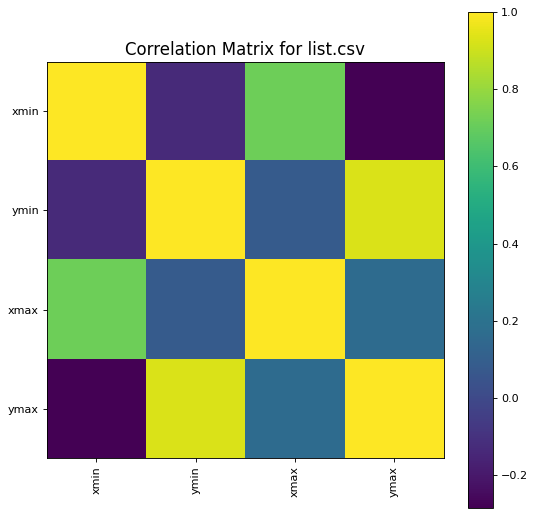

In [7]:
plotPerColumnDistribution(df1, 10, 5)
plotCorrelationMatrix(df1, 8)

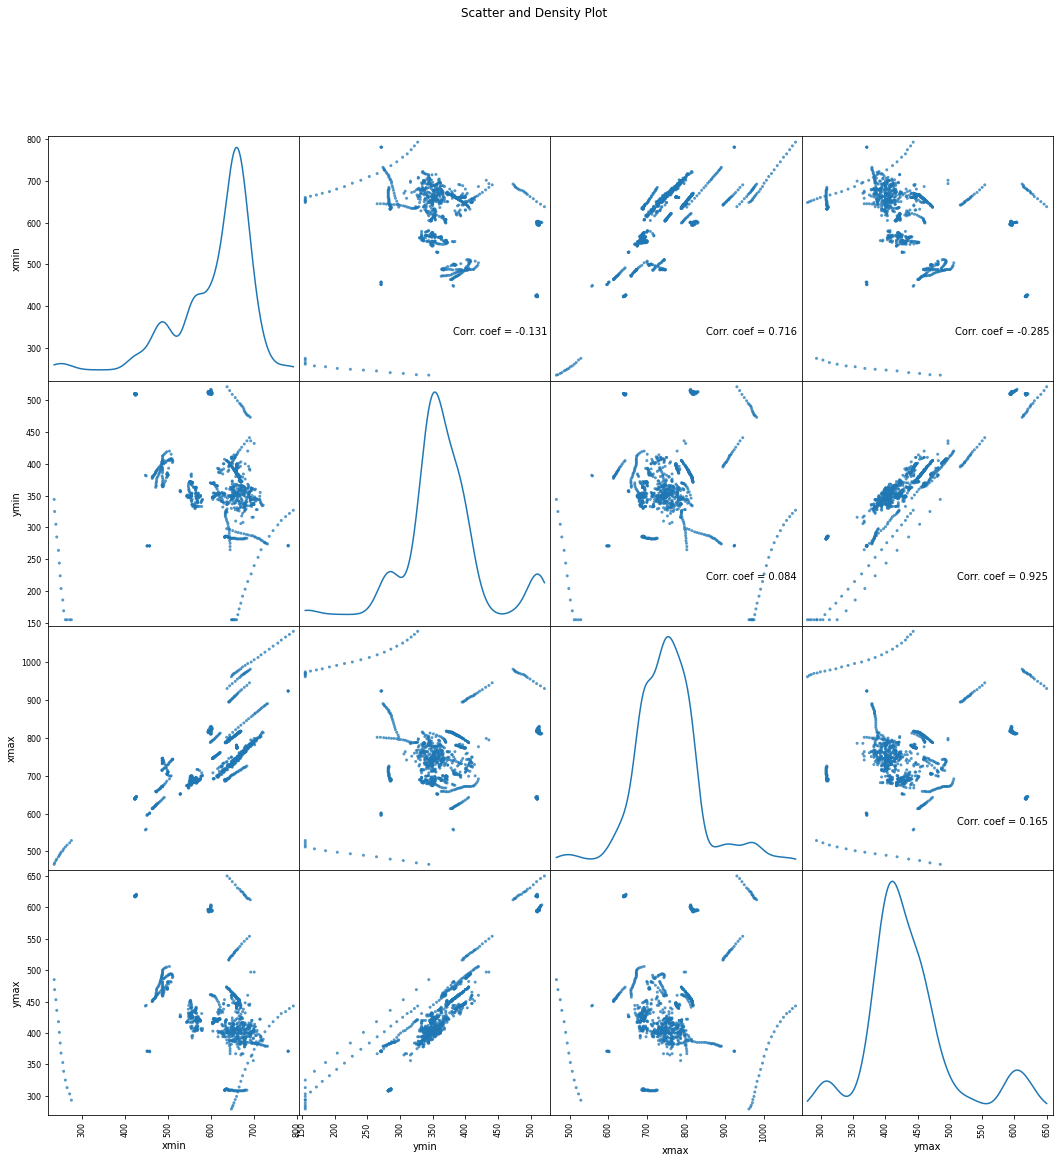

In [8]:
plotScatterMatrix(df1, 18, 10)

In [9]:
path_image = "set-lipstick-original/720p/"
path_mask = "set-lipstick-original/mask/"
labels = ['NoLips','Lips']

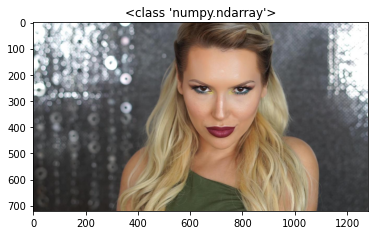

In [10]:
image1 = plt.imread(path_image+'image00000001.jpg')
fig, ax = plt.subplots()
ax.imshow(image1)
ax.set_title(type(image1))
plt.show()

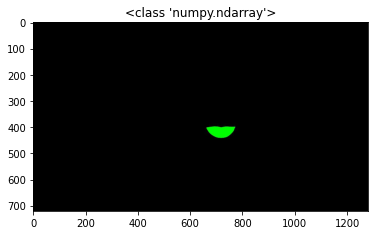

In [11]:
image1 = plt.imread(path_mask+'/mask00000001.png')
fig, ax = plt.subplots()
ax.imshow(image1)
ax.set_title(type(image1))
plt.show()

In [12]:
images = []

for root, dirs, files in os.walk(path_image):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            images.append(f)
        else:
            break

masks = []

for root, dirs, files in os.walk(path_mask):
    for name in files:
        f = os.path.join(root, name)
        if 'mask' in f:
            masks.append(f)
        else:
            break

In [13]:
len(images), len(masks), images[-1], masks[-1]

(28594,
 28540,
 'set-lipstick-original/720p/image00006187.jpg',
 'set-lipstick-original/mask/mask00020102.png')

In [14]:
images_w_mask = []

for img in images:
    for mask in masks:
        if img[-12:-4] == mask[-12:-4]:
            images_w_mask.append(img)
            break
            
masks_adapt = []

for img in images_w_mask:
    masks_adapt.append(f"set-lipstick-original/mask/mask{img[-12:-4]}.png")

In [15]:
len(images_w_mask), len(masks_adapt), images_w_mask[-1], masks_adapt[-1]

(28540,
 28540,
 'set-lipstick-original/720p/image00006187.jpg',
 'set-lipstick-original/mask/mask00006187.png')

In [16]:
df = pd.DataFrame({'images': images_w_mask, 'masks': masks_adapt})
df.sort_values(by='images', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head())

                                         images  \
0  set-lipstick-original/720p/image00000001.jpg   
1  set-lipstick-original/720p/image00000002.jpg   
2  set-lipstick-original/720p/image00000003.jpg   
3  set-lipstick-original/720p/image00000004.jpg   
4  set-lipstick-original/720p/image00000005.jpg   

                                         masks  
0  set-lipstick-original/mask/mask00000001.png  
1  set-lipstick-original/mask/mask00000002.png  
2  set-lipstick-original/mask/mask00000003.png  
3  set-lipstick-original/mask/mask00000004.png  
4  set-lipstick-original/mask/mask00000005.png  


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  28540 non-null  object
 1   masks   28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [18]:
img = np.asarray(Image.open(images_w_mask[0])).astype('float')
img.shape

(720, 1280, 3)

In [19]:
img = torch.as_tensor(img)/255
img = img.unsqueeze(0)
print(img.shape)
img = img.permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)

torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


In [20]:
mask_it = np.asarray(Image.open(masks_adapt[-1])).astype('int')
mask_it.shape

(720, 1280, 3)

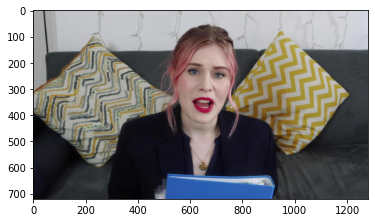

In [21]:
plt.imshow(Image.open(images_w_mask[-1]))

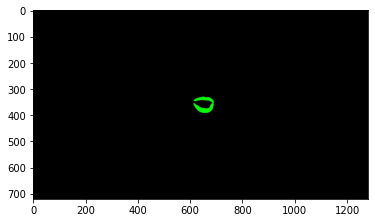

In [22]:
plt.imshow(mask_it)

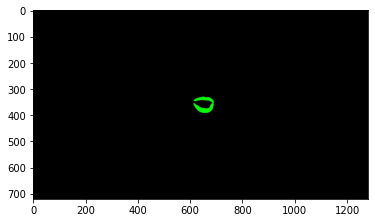

In [23]:
plt.imshow(Image.open(masks_adapt[-1]))

In [24]:
df1 = pd.read_csv('set-lipstick-original/list.csv', delimiter=',')
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 28594 rows and 9 columns


In [25]:
df1.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [26]:
min(mask_it[mask_it>0]), max(mask_it[mask_it>0]), np.mean(mask_it[mask_it>0])

(1, 255, 58.16660845267202)

In [27]:
mask_it[mask_it[:, :, 1]>0]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 2, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [28]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] 
lab.shape

(720, 1280)

In [29]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(0.003921569, 1.0, 0.48742545)

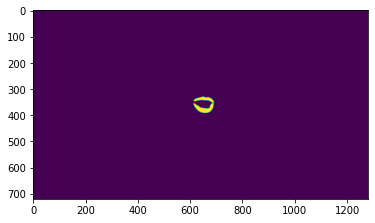

In [30]:
lab[lab>0.4] = 255
plt.imshow(lab)

In [31]:
lab_2 = np.asarray(Image.open(masks_adapt[-1]))[:,:,1]
lab_2.shape

(720, 1280)

In [32]:
min(lab_2[lab_2>0]), max(lab_2[lab_2>0]), np.mean(lab_2[lab_2>0])

(1, 255, 124.29349240780911)

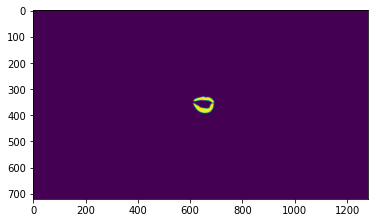

In [33]:
plt.imshow(lab_2)

In [34]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] 

lab.shape

(720, 1280)

In [35]:
lab[lab<0.4] = 0

lab[lab>=0.4] = 1

In [36]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(1.0, 1.0, 1.0)

In [37]:
lab = torch.as_tensor(lab)
print(lab.shape)
lab = lab.unsqueeze(0).unsqueeze(0)
print(lab.shape)
lab = F.interpolate(input=lab, size=256, mode='nearest')
print(lab.shape)

torch.Size([720, 1280])
torch.Size([1, 1, 720, 1280])
torch.Size([1, 1, 256, 256])


In [38]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]
f_lp = np.where(lab<0.4, 255, 0)
t_lp = np.where(lab>=0.4, 255, 0)
f_lp.shape, t_lp.shape

((720, 1280), (720, 1280))

In [39]:
df1.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [40]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]
f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)
t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')
lab.shape

torch.Size([1, 2, 256, 256])

In [41]:
X_data, X_test = train_test_split(df, test_size=0.23)

X_train, X_valid = train_test_split(X_data, test_size=0.23)

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train[:30])
valid_data = CustomDatasetFromImages(X_valid[:30])
test_data = CustomDatasetFromImages(X_test)

batch_s = 3

train_data_loader = DataLoader(train_data, batch_size=batch_s, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=batch_s, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [42]:
learning_rate = 0.001

epochs = 5
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters())
criterion = SoftDiceLoss()
path_checkpoint = "checkpoints_lp"
if not os.path.exists(path_checkpoint):
    os.mkdir(path_checkpoint)

In [43]:
epoch_losses = []

epoch_val_losses = []

In [44]:
for epoch in range(epochs):  
    running_loss = 0.0
    cum_loss = []

    print(f'Epoch: {epoch+1}')
    time1 = time.time()
    segmodel.train()
    for i, data in enumerate(train_data_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device) # .cuda()
        labels = labels.to(device) # .cuda()

        optimizer.zero_grad()

        outputs = segmodel(inputs[0])
        loss = criterion(outputs, labels[0,:,:,:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        cum_loss.append(loss.item())
        if not (i+1) % 10:   
            print(f'\tbatchcount: {i+1}, avg. loss for last {batch_s*10} images: {running_loss/(batch_s*10):.5f}')
            running_loss = 0.0

    time2 = time.time()
    epoch_losses.append(np.mean(cum_loss))
    torch.save(segmodel.state_dict(), path_checkpoint + f"/checkpoint_lp_ep_{epoch+1}.pth")

    cum_loss = []
    segmodel.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # .cuda()
            labels = labels.to(device) # .cuda()

            outputs = segmodel(inputs[0])
            loss = criterion(outputs, labels[0,:,:,:])

            running_val_loss += loss.item()
            cum_loss.append(loss.item())

    epoch_val_losses.append(np.mean(cum_loss))
    print(f'\n  Epoch {epoch+1}, loss: {epoch_losses[-1]:.5f} loss_val: {epoch_val_losses[-1]:.5f} time = {time2-time1:.2f} sec\n')

Epoch: 1


/usr/local/lib/python3.9/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


	batchcount: 10, avg. loss for last 30 images: -0.01867

  Epoch 1, loss: -0.05600 loss_val: -0.14836 time = 12.95 sec

Epoch: 2
	batchcount: 10, avg. loss for last 30 images: -0.19917

  Epoch 2, loss: -0.59751 loss_val: -0.67047 time = 13.06 sec

Epoch: 3
	batchcount: 10, avg. loss for last 30 images: -0.26944

  Epoch 3, loss: -0.80831 loss_val: -0.85436 time = 12.44 sec

Epoch: 4
	batchcount: 10, avg. loss for last 30 images: -0.29914

  Epoch 4, loss: -0.89741 loss_val: -0.90225 time = 12.14 sec

Epoch: 5
	batchcount: 10, avg. loss for last 30 images: -0.31082

  Epoch 5, loss: -0.93245 loss_val: -0.93317 time = 12.71 sec



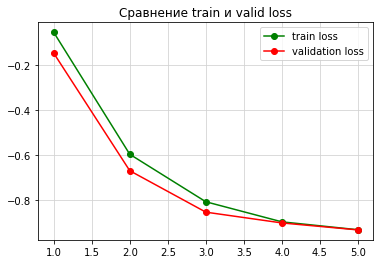

In [45]:
plt.plot(np.arange(1, 6), epoch_losses, 'go-', label='train loss')
plt.plot(np.arange(1, 6), epoch_val_losses, 'ro-', label='validation loss')

plt.legend(loc="upper right")
plt.grid(color="lightgrey")
plt.title('Сравнение train и valid loss' )
plt.show()

In [46]:
net_out = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
net_out.load_state_dict(torch.load(path_checkpoint + f"/checkpoint_lp_ep_5.pth"))

<All keys matched successfully>

/usr/local/lib/python3.9/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


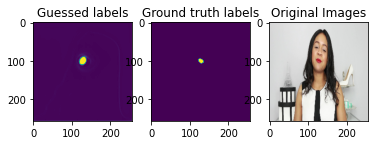

/var/folders/tw/jpryffr53r5_9z9t7wz7rbv80000gn/T/ipykernel_2168/819762285.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

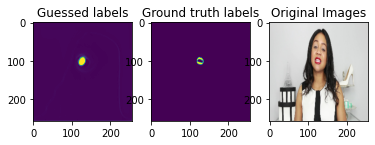

<Figure size 432x288 with 0 Axes>

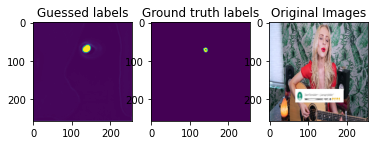

<Figure size 432x288 with 0 Axes>

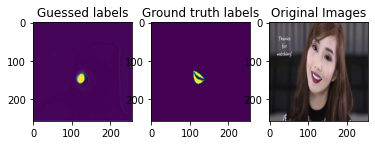

<Figure size 432x288 with 0 Axes>

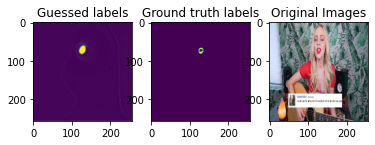

<Figure size 432x288 with 0 Axes>

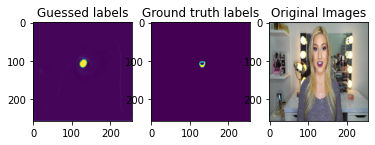

<Figure size 432x288 with 0 Axes>

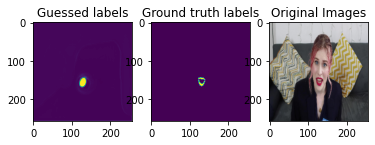

<Figure size 432x288 with 0 Axes>

In [47]:
%matplotlib inline

for i, data in enumerate(valid_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net_out(images[0])
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[0,:,:])
    axarr[0].set_title('Guessed labels')    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')  
    original = images[0][0,:,:,:].cpu()
    original = original.permute(1, 2, 0)
    original = original.numpy()
    original = np.clip(original, 0, 1)
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break